In [1]:
from datascience import *
import numpy as np
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

## Review

### The $k$-Nearest Neighbors algorithm

#### Find the “distance” between the example and one training point

##### We use $\text{D}$, the **Euclidean distance:**

$$ \text{D} = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2} $$

In [2]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sum((point1-point2)**2) ** 0.5

#### Find the “distance” between the example and each observation in the training set

In [3]:
def all_distances(training, new_row):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_new(row):
        return distance(make_array(new_row), make_array(row))
    return attributes.apply(distance_from_new)

#### Augment the training data table with a column containing all the distances

In [4]:
def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

#### The smaller $\text{D}$ is, the nearer the neighbor! Find the $k$-nearest neighbors using table manipulations.

In [5]:
def nearest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    nearest_neighbors_table = sorted_by_distance.take(np.arange(k))
    return nearest_neighbors_table

#### Take a majority vote of the $k$-nearest neighbors. Assign the new point to the majority class

In [6]:
def majority(nearest_neighbors_table, class_name):
    return nearest_neighbors_table.group(class_name).sort('count', 
                                                         descending=True).column(class_name).item(0)

#### A function to run the complete algorithm!

In [7]:
def one_knn(training, class_name, new_point, k):
    nearest_neighbors_table = nearest(training, new_point, k)
    return majority(nearest_neighbors_table, class_name)

____

### `ckd` dataset

In [8]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.sample(3).show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1
15,80,1.025,0,0,normal,normal,notpresent,notpresent,93,17,0.9,136,3.9,16.7,50,6200,5.2,no,no,no,good,no,no,0
55,80,1.02,0,0,normal,normal,notpresent,notpresent,104,28,0.9,142,4.8,17.3,52,8200,4.8,no,no,no,good,no,no,0


In [9]:
ckd = ckd.select('Hemoglobin','Glucose','White Blood Cell Count', 'Class')

_____

### `banknotes` dataset

In [10]:
banknotes = Table().read_table('banknote.csv')
banknotes.sample(3).show()

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
2.4527,2.9653,0.20021,-0.056479,0
0.64295,7.1018,0.3493,-0.41337,0
3.2422,6.2265,0.12224,-1.4466,0


In [11]:
first_banknote = banknotes.drop('Class').row(0)
first_banknote

Row(WaveletVar=3.6215999999999999, WaveletSkew=8.6661000000000001, WaveletCurt=-2.8073000000000001, Entropy=-0.44699)

**Distance in 4 dimensions**

$$ \text{D} = \sqrt{(w_0-w_1)^2 + (x_0-x_1)^2 + (y_0-y_1)^2 + (z_0-z_1)^2} $$

In [12]:
banknotes.show(1)

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0


In [13]:
nearest(banknotes,first_banknote,1)

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Distance
3.6216,8.6661,-2.8073,-0.44699,0,0


**Discussion Question**

## New material

In [14]:
patients = Table.read_table('breast-cancer.csv').drop('ID')

In [15]:
patients.sample(5).show()

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
3,1,1,1,2,1,2,1,1,0
3,4,5,3,7,3,4,6,1,0
10,6,4,1,3,4,3,2,3,1
1,1,1,2,2,1,2,1,1,0
6,6,7,10,3,10,8,10,2,1


In [16]:
patients.num_columns

10

### Exploration

In [17]:
patients.group('Class')

Class,count
0,444
1,239


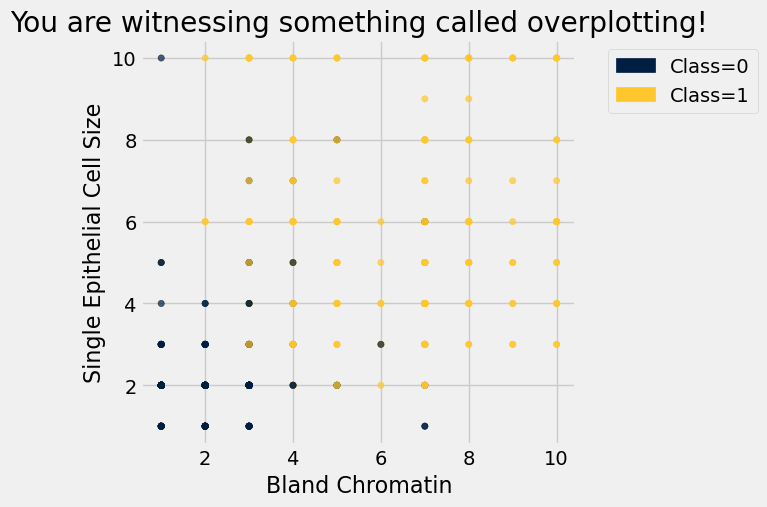

In [18]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')
plt.title('You are witnessing something called overplotting!');

Do not worry about how to use the code below. Just understand that it makes a new table containing data which enhance the previous visualization!

In [19]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

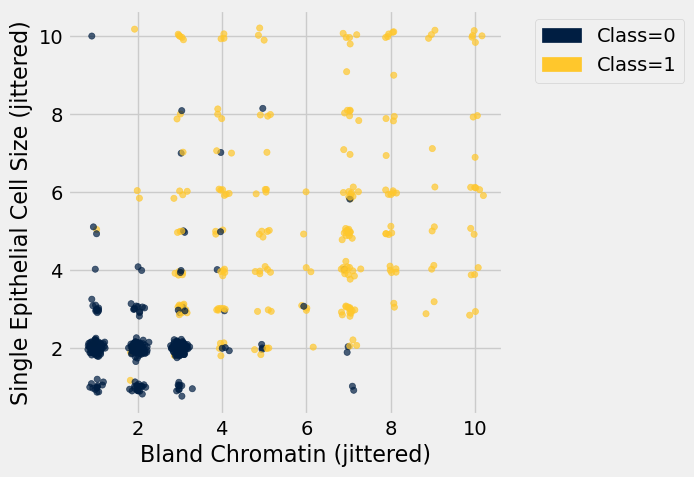

In [20]:
jittered.scatter(0, 1, group='Class')

____

### Prediction

#### **Task**: Split the `patients` data into `train` and `test` sets of (roughly) equal size.

##### Method 1: from yesterday - use the `sample` + `take` table methods

In [21]:
halfway = round(patients.num_rows/2)
halfway

342

In [22]:
shuffled_patients = patients.sample(with_replacement=False)

In [23]:
train = shuffled_patients.take(np.arange(halfway))
test = shuffled_patients.take(np.arange(halfway, patients.num_rows))

##### Method 2: use the `split` table method!
- If you're confused about what's going on here - don't feel bad. This code involves the use of a data type in Python called a `tuple`, which is beyond the scope of the course. You can just use code like this to speed up the train and test split, if you wish.

In [24]:
train, test = patients.split(k = round(patients.num_rows/2))

#### **Task**: Calculate the Euclidean distance between an example test point and every point in the training set.

In [25]:
example = test.drop('Class').row(2)
example

Row(Clump Thickness=5, Uniformity of Cell Size=1, Uniformity of Cell Shape=1, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=1, Bland Chromatin=1, Normal Nucleoli=1, Mitoses=1)

**Discussion Question**

In [26]:
table_with_distances(train, example)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
2,1,1,1,2,1,3,1,1,0,4.12311
10,9,7,3,4,2,7,7,1,1,14.2127
5,1,1,6,3,1,1,1,1,0,3.16228
4,1,1,1,2,1,1,1,1,0,2.23607
8,2,4,1,5,1,5,4,4,1,8.12404
10,4,4,6,2,10,2,3,1,1,11.7473
8,10,10,10,6,10,10,10,1,1,21.8861
7,5,6,3,3,8,7,4,1,1,11.8322
10,8,10,1,3,10,5,1,1,1,16.0312
1,1,1,1,2,1,1,1,1,0,4.47214


#### **Task**: Find the 5-nearest neighbors!

In [27]:
nearest(train, example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,1,1,3,2,1,1,1,1,0,0
5,1,1,3,2,1,1,1,1,0,0
6,1,1,3,2,1,1,1,1,0,1
4,1,1,3,2,1,1,1,1,0,1
4,1,1,2,2,1,1,1,1,0,1.41421


#### **Task**: Find the majority class!

In [28]:
majority(nearest(train, example, 5), 'Class')

0

#### **Task**: Repeat this process for every point in the testing set!

In [29]:
one_knn(train, 'Class', test.drop('Class').row(0),  5)

0

There are a few ways to do this. Today, we will use a for-loop method because it requires writing less functions.

In [30]:
def knn(training, class_name, testing, k):
    """Returns the test predictions in the test set in a table, along with their actual classifications"""
    
    predictions = make_array()
    for i in np.arange(testing.num_rows):
        predictions = np.append(predictions, one_knn(training, 
                                                     class_name, 
                                                     testing.drop(class_name).row(i), 
                                                     k))

    knn_table = Table().with_columns('Actual', testing.column(class_name),
                                     'Predicted', predictions)
    
    return knn_table 

In [31]:
results = knn(train, 'Class', test, 5)
results

Actual,Predicted
0,0
1,1
0,0
0,0
1,1
0,0
1,1
1,1
0,0
1,1


#### **Task**: Evaluate the accuracy of the classifier using $k=5$.

$$\text{Misclassification Rate (MCR)} = \text{proportion of testing points that are misclassified}$$

- Practice [5 min]: Find the mis-classification rate for the 5-nearest neighbors algorithm!
  - Can you find the number of misclassified points?
  - Can you find the total number of points in the `test` table?
  - If you can do both of these, you should be able to answer this question!

In [32]:
np.average(results.column('Actual') != results.column('Predicted'))

0.038123167155425221

#### **Task**: See where our classifier went wrong.

**Discussion Question**: How many rows and columns will the table produced by the following command have?

```
results.group(['Actual', 'Predicted'])
```


In [33]:
results.group(['Actual', 'Predicted'])

Actual,Predicted,count
0,0,214
0,1,6
1,0,7
1,1,114


**Discussion Question**

### If you are purely interested in prediction... standardize!

In [34]:
def standard_units(x):
    return (x - np.average(x)) / np.std(x)

In [35]:
ckd.sample(3).show(3)

Hemoglobin,Glucose,White Blood Cell Count,Class
16.6,93,7100,0
8.3,107,12400,1
9.9,94,16700,1


In [36]:
ckd_train,ckd_test = ckd.split(k = round(ckd.num_rows/2))

In [37]:
ckd_results = knn(ckd_train, 'Class', ckd_test, 5)
np.average(ckd_results.column('Actual') != ckd_results.column('Predicted'))

0.22784810126582278

In [38]:
std_ckd_train = ckd_train.select('Class').with_columns(
    'Glucose_su', standard_units(ckd_train.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd_train.column('Hemoglobin')),
    'WBC_su', standard_units(ckd_train.column('White Blood Cell Count'))
)

In [39]:
std_ckd_test = ckd_test.select('Class').with_columns(
    'Glucose_su', standard_units(ckd_test.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd_test.column('Hemoglobin')),
    'WBC_su', standard_units(ckd_test.column('White Blood Cell Count'))
)

In [40]:
std_ckd_results = knn(std_ckd_train, 'Class', std_ckd_test, 5)
np.average(std_ckd_results.column('Actual') != std_ckd_results.column('Predicted'))

0.037974683544303799

## Appendix

### Which $k$ should we choose?

We can figure out which one based on the evaluation metric, $\text{MCR}$. 

This step should be performed on the training set, *not* the testing set. Usually, we end up splitting the original training set into two parts: 

- "new" training set
- validation set.

In [41]:
new_train, validation = train.split(k = round(train.num_rows*(7/10)))

In [42]:
new_train.num_rows

239

In [43]:
validation.num_rows

103

In [55]:
def which_k(training, class_name, validation, k_values):

    mc_rates = make_array()

    for i in np.arange(np.size(k_values)):

        results = knn(training, class_name, validation, k_values.item(i))
        new_rate = np.average(results.column('Actual') != results.column('Predicted'))
        mc_rates = np.append(mc_rates, new_rate)

    k_table = Table().with_columns("k", k_values,
                                   "MCR", mc_rates)
                             
    return k_table

In [66]:
k_s = make_array(1,3,5,7,9,11,13,15,17,19,21,23,25)

In [67]:
k_table = which_k(new_train, 'Class', validation, k_s)

In [68]:
k_table

k,MCR
1,0.038835
3,0.0291262
5,0.0291262
7,0.0194175
9,0.00970874
11,0.00970874
13,0.00970874
15,0.00970874
17,0.0194175
19,0.0194175


**Discussion Question**: What plot type would work best to visualize how the $\text{MCR}$ increases and decreases as the number of neighbors increases?

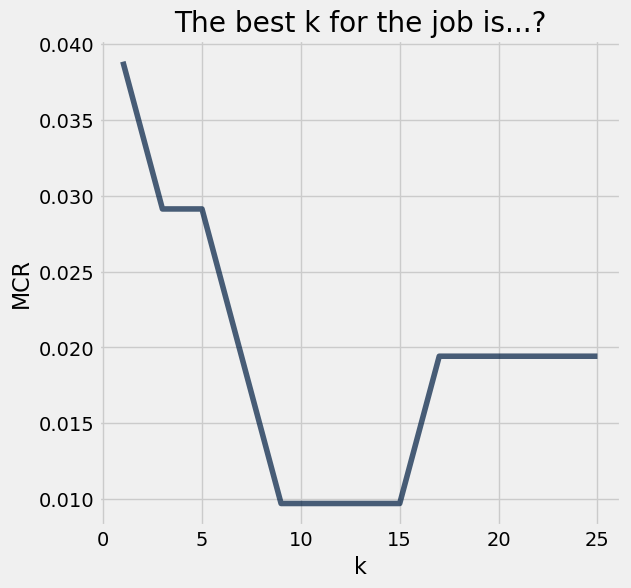

In [69]:
k_table.plot('k','MCR')
plt.title('The best k for the job is...?');

#### **Task**: Evaluate our classifier's performance on the test set using the best $k$: ($k = 3$).

In [70]:
results = knn(train, 'Class', test, 9)

In [71]:
np.average(results.column('Actual') != results.column('Predicted'))

0.03519061583577713